# Forecasting using SVM

- One-step recursive forecasting

In [1]:
import pandas as pd
import numpy as np
import os
import time

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


# accuracy measures and data spliting
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler

import graphviz
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = 15, 7

## 1. Data import

In [4]:
DATADIR = '../data/power-consumption/'
MODELDIR = '../checkpoints/power/svm/model/'

In [5]:
# directory for saving model 
if os.path.exists(MODELDIR):
    pass
else:
    os.makedirs(MODELDIR)

In [6]:
data = pd.read_csv(os.path.join(DATADIR, 'processed_data.csv'))

In [7]:
data.head()

,date,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Sub_metering_4,Month,Weekday,WeekOfYear,Median_active_power,Lagged_active_power,median_residual
0,2006-12-16,1209.176,34.922,236.243763,5180.8,0.0,546.0,4926.0,14680.933333,12,5,50,2437.799,2437.799,-1228.623
1,2006-12-17,3390.460,226.006,240.087028,14398.6,2033.0,4187.0,13341.0,36946.666667,12,6,50,2437.894,1209.176,952.566
2,2006-12-18,2203.826,161.792,241.231694,9247.2,1063.0,2621.0,14018.0,19028.433333,12,0,51,1833.155,3390.460,370.671
3,2006-12-19,1666.194,150.942,241.999313,7094.0,839.0,7602.0,6197.0,13131.900000,12,1,51,1971.630,2203.826,-305.436
4,2006-12-20,2225.748,160.998,242.308063,9313.0,0.0,2648.0,14063.0,20384.800000,12,2,51,2031.487,1666.194,194.261


## 2. Train test split

In [8]:
y = data[['Global_active_power']].copy()
X = data.drop(columns=['date', 'Global_active_power', 'Median_active_power', 'Lagged_active_power', 'median_residual'], axis=1)

# last 40 weeks data for testing
test_size = np.int16(7*1)
train_size = X.shape[0] - test_size

# scaling weekly sales, dependent variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y.values)

# scaling numerical column from features
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X.values)

X_train, X_test = X_scaled[:train_size-1, :], X_scaled[train_size:, :]
y_train, y_test = y_scaled[:train_size-1, :], y_scaled[train_size:, :]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1434, 10), (7, 10), (1434, 1), (7, 1))

## 3. Grid search

In [9]:
# grid_param = {
#     'C': [0.1, 1, 10, 100],
#     'epsilon' : [0.1, 0.2, 0.3]
# }

# svm = SVR(gamma='scale', cache_size=5120)
# svm_grid = GridSearchCV(estimator=svm, param_grid=grid_param)
# svm_grid.fit(X_train, y_train)
# print(f'Best Paramters: {svm_grid.best_params_}')

## 4. Model fitting

In [10]:
def svm_model(X_train, y_train):
    
    start = time.time()
    
    model = SVR(kernel='poly', epsilon=0.1, C=100, cache_size=5120, degree=3)
    
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    
    onestep_pred = []
    for i in range(X_test.shape[0]):
        model.fit(X_train, y_train)

        pred = model.predict(X_test[i, :].reshape(1, -1))
        onestep_pred.append(pred)

        tempX = np.vstack((X_train, X_test[i, :]))    
        X_train_v = tempX.copy()

        arr_pred = np.array([pred]).reshape(-1, 1)
        tempY = np.vstack((y_train, arr_pred))
        y_train_v = tempY.copy()
    
    y_test_pred = np.array(onestep_pred)
    
    end = time.time()
    time_taken = np.round((end-start), 3)
    print(f'Time taken to complete the process: {time_taken} seconds')
    
    return y_train_pred, y_test_pred

In [11]:
y_train_pred, y_test_pred = svm_model(X_train, y_train)

Time taken to complete the process: 125.457 seconds


## 5. Model evaluation

In [12]:
def model_evaluation(y_train, y_test, y_train_pred, y_test_pred):
    
    y_train_inv = y_scaler.inverse_transform(y_train)
    y_test_inv = y_scaler.inverse_transform(y_test)
    
    y_train_pred_inv = y_scaler.inverse_transform(y_train_pred)
    y_test_pred_inv = y_scaler.inverse_transform(y_test_pred)
    
    # MAE and NRMSE calculation
    train_rmse = np.sqrt(mean_squared_error(y_train_inv, y_train_pred_inv))
    train_mae = np.round(mean_absolute_error(y_train_inv, y_train_pred_inv), 3)
    train_nrmse = np.round(train_rmse/np.std(y_train_inv), 3)

    test_rmse = np.sqrt(mean_squared_error(y_test_inv, y_test_pred_inv))
    test_mae = np.round(mean_absolute_error(y_test_inv, y_test_pred_inv), 3)
    test_nrmse = np.round(test_rmse/np.std(y_test_inv), 3)

    print(f'Training MAE: {train_mae}')
    print(f'Trainig NRMSE: {train_nrmse}')

    print(f'Test MAE: {test_mae}')
    print(f'Test NRMSE: {test_nrmse}')
    
    return y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv

In [13]:
y_train_inv, y_train_pred_inv, y_test_inv, y_test_pred_inv = model_evaluation(y_train, y_test, y_train_pred, y_test_pred)

Training MAE: 133.996
Trainig NRMSE: 0.306
Test MAE: 97.3
Test NRMSE: 0.287


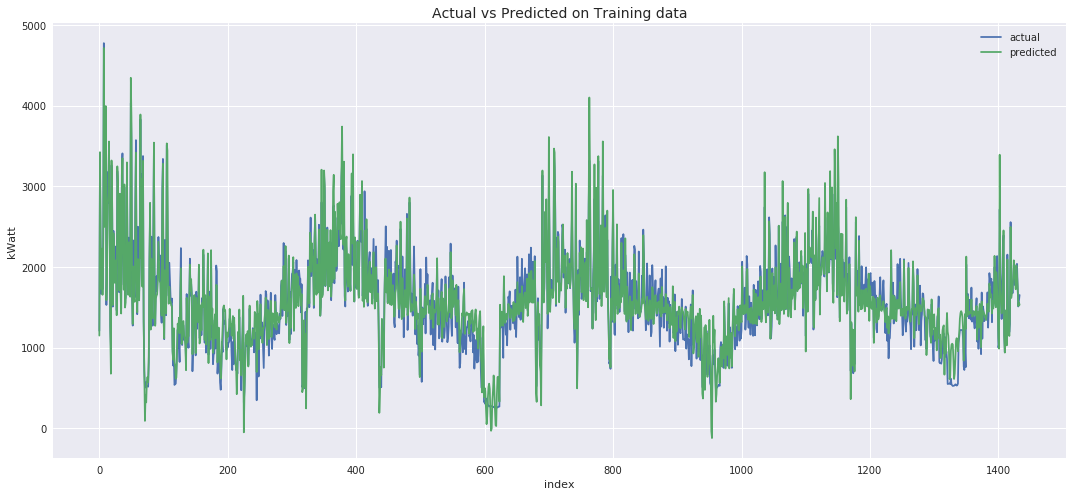

In [14]:
plt.plot(y_train_inv, label='actual')
plt.plot(y_train_pred_inv, label='predicted')
plt.ylabel('kWatt')
plt.xlabel('index')
plt.title('Actual vs Predicted on Training data', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

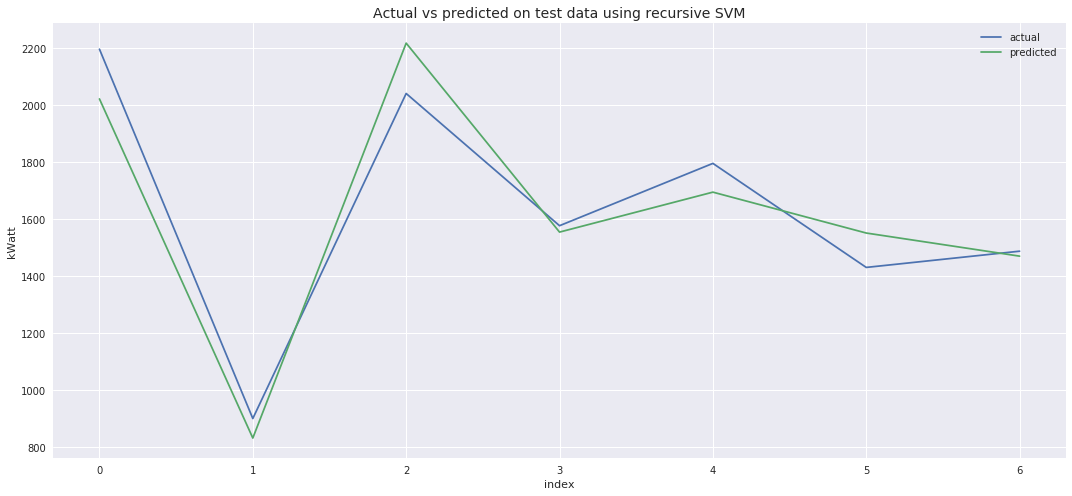

In [15]:
plt.plot(y_test_inv, label='actual')
plt.plot(y_test_pred_inv, label='predicted')
plt.ylabel('kWatt')
plt.xlabel('index')
plt.title('Actual vs predicted on test data using recursive SVM', fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()